# Imports

In [0]:
#If you are running the notebook in Colab it is necessary to toggle tensorflow 2.0 behaviour and load tennsorboard extension
%tensorflow_version 2.x
%load_ext tensorboard

In [0]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K


import glob
import os
import re
import datetime

from PIL import Image


import numpy as np
import pandas as pd

from sklearn.metrics import multilabel_confusion_matrix


from hyperopt import hp
from hyperopt import fmin, pyll, tpe, hp, STATUS_OK, Trials

import pickle
import time

import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.collections import PolyCollection
from mpl_toolkits.mplot3d import Axes3D


TensorFlow 2.x selected.


<font size = '+1'>If you are using Google Colaboratory you might want to download preprocessed images from google drive. If so put your file id in the cell below and run it.</font>

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Put google drive zip archive id here
google_drive_file_id = 'zip archive id'

download = drive.CreateFile({'id': google_drive_file_id})
download.GetContentFile('tiles.zip')

!unzip -q tiles.zip

# Data Generators

In [0]:
directory = 'tiles'

files = glob.glob(os.path.join(directory,'*'))

pattern_img = '.*\.jpg'
files_img = list(filter(re.compile(pattern_img).match,files))

pattern_mask = '.*\.tif'
files_mask = list(filter(re.compile(pattern_mask).match,files))

files_mask = sorted(files_mask)
files_img = sorted(files_img)

print(' All files: {}\n'.format(len(files)),
      'Image files: {}\n'.format(len(files_img)),
      'Mask files: {}'.format(len(files_mask)))

 All files: 7702
 Image files: 3851
 Mask files: 3851


In [0]:
df_files = pd.DataFrame(columns=['img','mask'])
df_files['img'] = files_img
df_files['mask'] = files_mask

df_files = df_files.sample(frac=1,random_state=10)

train_bound = int(len(df_files) * 0.7)
val_bound = int(len(df_files) * 0.85)

df_train = df_files.iloc[:train_bound]
df_val = df_files.iloc[train_bound:val_bound]
df_test = df_files.iloc[val_bound:]

print(' Train examples: {}\n'.format(len(df_train)),
      'Validation examples: {}\n'.format(len(df_val)),
      'Test examples: {}\n'.format(len(df_test)))

 Train examples: 2695
 Validation examples: 578
 Test examples: 578




Image and respective mask examples

Found 10 validated image filenames.
Found 10 validated image filenames.


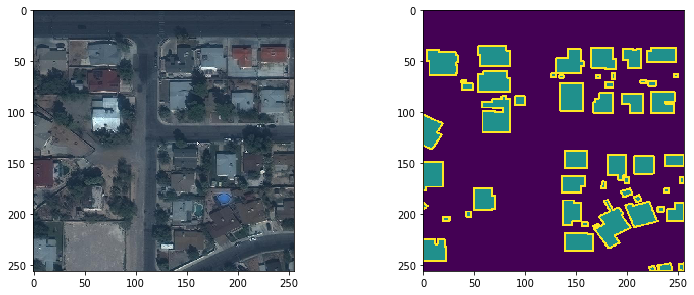

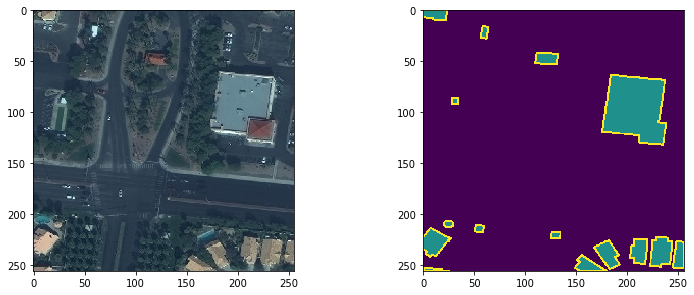

In [0]:
def make_tuple_gen(df_files,target_size,batch_size,seed):

  img_gen = keras.preprocessing.image.ImageDataGenerator()
     
  img_generator = img_gen.flow_from_dataframe(
          dataframe=df_files,        
          x_col='img',
          target_size=target_size,
          batch_size=batch_size,
          seed = seed,
          class_mode=None,
          color_mode='rgb')
  
  mask_gen = keras.preprocessing.image.ImageDataGenerator()

  mask_generator = mask_gen.flow_from_dataframe(
          dataframe=df_files,        
          x_col='mask',
          target_size=target_size,
          batch_size=batch_size,
          seed = seed,
          class_mode=None,
          color_mode='grayscale')


  return zip(img_generator, mask_generator)

def make_gen4unet(df_files,target_size = (256, 256),batch_size = 1,seed = 10):
  
  tuple_gen =  make_tuple_gen(df_files,target_size,batch_size,seed)

  def _gen():  
    while True:
      x,y = next(tuple_gen)
      
      y[y==100] = 1
      y[y==255] = 2

      yield x,y

  return _gen()

print('\nImage and respective mask examples\n')

genUnet = make_gen4unet(df_files.head(10))
for i in range(2):
  xx,yy = next(genUnet)
  xx = xx[0].astype(int)
  yy = np.squeeze(yy[0].astype(int))


  plt.figure(figsize=1*np.array([2*6.4, 4.8]))
  plt.subplot(121)
  plt.imshow(xx)
  plt.subplot(122)
  plt.imshow(yy)
  plt.show()

In [0]:
train_gen = make_gen4unet(df_train,batch_size=30)
val_gen   = make_gen4unet(df_val,batch_size=30)
test_gen  = make_gen4unet(df_test,batch_size=578)

Found 2695 validated image filenames.
Found 2695 validated image filenames.
Found 578 validated image filenames.
Found 578 validated image filenames.
Found 578 validated image filenames.
Found 578 validated image filenames.


# Model

In [0]:
def reduce_layer(n_classes):
  """The idea of this layer is the foollwing:
  Original Unet has final conv layer with three filters. 
  Each filter has to be able to distinguish target class on the final feature map.
  Each filter has capacity of only 65 parameters, which might be insufficient.
  Improoved Unet has increased number of filters per class in final conv layer.
  There are three groups of filters as per each class. Filters corresponding to 
  one classes are summed in the final layer before activation. 
  """
  
  def _reduce_layer(x):

    n_channel = x.shape[-1]
        
    # n_channel must be devisible by n_classes
    assert n_channel % n_classes == 0

    ch1 = int(n_channel/n_classes)
    ch2 = int(2*n_channel/n_classes)
    
    x1 = x[...,:ch1]
    x2 = x[...,ch1:ch2]
    x3 = x[...,ch2:n_channel]

    x1 = K.sum(x1,axis=-1)
    x2 = K.sum(x2,axis=-1)
    x3 = K.sum(x3,axis=-1)

    y = K.stack([x1,x2,x3],axis=-1)

    return y

  return _reduce_layer

def conv_block(n_filter,batch_norm=True):

  def _conv_block(x):
  
    if batch_norm:
  
      x = keras.layers.Conv2D(n_filter, (3,3),padding='same')(x)
      x = keras.layers.BatchNormalization()(x)
      x = keras.layers.ReLU()(x)
    
    else:  
  
      x = keras.layers.Conv2D(n_filter, (3,3),padding='same')(x)    
      x = keras.layers.ReLU()(x)

    return x

  return _conv_block

def unetConv2(n_filter,double_conv=True,batch_norm=True):
  
  def _unetConv2(x):
    
    if double_conv:    
    
      x = conv_block(n_filter,batch_norm) (x)
      x = conv_block(n_filter,batch_norm) (x)    
    
    else:    
    
      x = conv_block(n_filter,batch_norm) (x)
    
    return x

  return _unetConv2

def unetUp(n_filter,deconv=True):

  def _unetUp(input1,input2):

    if deconv:

      input2 = keras.layers.Conv2DTranspose(n_filter,(2,2),(2,2))(input2)
          
    else:
      
      input2 = keras.layers.UpSampling2D(size=(2,2))(input2)

    x = keras.layers.Concatenate()([input1,input2])

    return x

  return _unetUp

def unetModel(n_classes = 3,image_shape = (256,256,3) ,feature_scale=1, deconv=True, 
                 in_channels=3, double_conv=True, batch_norm=True, 
                 final_reduce=True,final_reduce_n_channel=30):
  
  """final_reduce_n_channel must be devisible by n_classes"""

  filters = [32, 64, 128, 256, 512]
  filters = [x // feature_scale for x in filters]

  x = keras.layers.Input(image_shape)

  conv1 = unetConv2(filters[0],double_conv,batch_norm) (x)
  maxpool1 = keras.layers.MaxPool2D(pool_size = (2,2)) (conv1)

  conv2 = unetConv2(filters[1],double_conv,batch_norm) (maxpool1)
  maxpool2 = keras.layers.MaxPool2D(pool_size = (2,2)) (conv2)

  conv3 = unetConv2(filters[2],double_conv,batch_norm) (maxpool2)
  maxpool3 = keras.layers.MaxPool2D(pool_size = (2,2)) (conv3)

  conv4 = unetConv2(filters[3],double_conv,batch_norm) (maxpool3)
  maxpool4 = keras.layers.MaxPool2D(pool_size = (2,2)) (conv4)

  center = unetConv2(filters[4],double_conv,batch_norm) (maxpool4)

  up_concat4 = unetUp(filters[3],deconv) (conv4,center)
  up_concat3 = unetUp(filters[2],deconv) (conv3,up_concat4)
  up_concat2 = unetUp(filters[1],deconv) (conv2,up_concat3)
  up_concat1 = unetUp(filters[0],deconv) (conv1,up_concat2)
  

  if final_reduce:

    final = keras.layers.Conv2D(final_reduce_n_channel,(1,1)) (up_concat1)
    final = keras.layers.Lambda(reduce_layer(n_classes)) (final)

  else:

    final = keras.layers.Conv2D(n_classes,(1,1)) (up_concat1)

  final_softmax = keras.activations.softmax(final, axis=-1)

  model  = keras.Model(x,final_softmax)  

  return model

# Baseline

## Baseline Training

In [0]:
model_base_line = unetModel(final_reduce=False)

model_base_line.compile(optimizer='adam',metrics = ['sparse_categorical_accuracy'],loss= 'sparse_categorical_crossentropy')

In [0]:
%%time
logdir = 'log_dir/base_line/0'

os.makedirs(logdir,exist_ok=True)


callbacks = [keras.callbacks.TensorBoard(log_dir=logdir,
                                        histogram_freq=1,
                                        update_freq = 'epoch',                                     
                                        write_graph=True
                                        )]
                                        

history_base_line = model_base_line.fit_generator(train_gen, 
                              steps_per_epoch=25, 
                              epochs=10,
                              verbose=1, 
                              validation_data=val_gen,
                              validation_steps=19,
                              callbacks=callbacks)

Epoch 1/10
25/25 [==============================] - 19s 745ms/step - loss: 0.5848 - sparse_categorical_accuracy: 0.7657 - val_loss: 1.5765 - val_sparse_categorical_accuracy: 0.2995
Epoch 2/10
25/25 [==============================] - 14s 578ms/step - loss: 0.4213 - sparse_categorical_accuracy: 0.8448 - val_loss: 1.4813 - val_sparse_categorical_accuracy: 0.4560
Epoch 3/10
25/25 [==============================] - 14s 572ms/step - loss: 0.3576 - sparse_categorical_accuracy: 0.8704 - val_loss: 1.1336 - val_sparse_categorical_accuracy: 0.5299
Epoch 4/10
25/25 [==============================] - 15s 616ms/step - loss: 0.3233 - sparse_categorical_accuracy: 0.8815 - val_loss: 0.7807 - val_sparse_categorical_accuracy: 0.7102
Epoch 5/10
25/25 [==============================] - 14s 572ms/step - loss: 0.2940 - sparse_categorical_accuracy: 0.8919 - val_loss: 0.4198 - val_sparse_categorical_accuracy: 0.8435
Epoch 6/10
25/25 [==============================] - 14s 569ms/step - loss: 0.2709 - sparse_cate

## Baseline Validation

In [0]:
def validate_image(img,mask,model):

    mask_pred = model.predict(img)

    i=0
    img = img[i].astype(int)
    mask = np.squeeze(mask[i].astype(int))
    mask_pred = np.squeeze(mask_pred[i])
    mask_pred_rend = np.argmax(mask_pred,axis=-1)

    plt.figure(figsize=0.8*np.array([4*6.4, 4.8]))
    plt.subplot(141)
    plt.imshow(img)
    plt.subplot(142)
    plt.imshow(mask)
    plt.subplot(143)
    plt.imshow(mask_pred)
    plt.subplot(144)
    plt.imshow(mask_pred_rend)
    plt.show()
    
    return mask_pred, mask_pred_rend

def plot_history(history_dict):

  metrics = ['loss', 'sparse_categorical_accuracy']
  val_metrics = ['val_los', 'val_sparse_categorical_accuracy']


  epochs = range(1, len(history_dict['loss']) + 1)

  plt.figure(figsize=0.8*np.array([6*6.4, 4.8]))
  
  for i,metric in enumerate(metrics):
    plt.subplot(141+i)    
    plt.plot(epochs, history_dict[metric], 'bo', label='Training ' + metric)
    plt.plot(epochs, history_dict['val_' + metric], 'b', label='Validation' + metric)
    plt.title('Training and validation ' + metric)
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()


  plt.show()

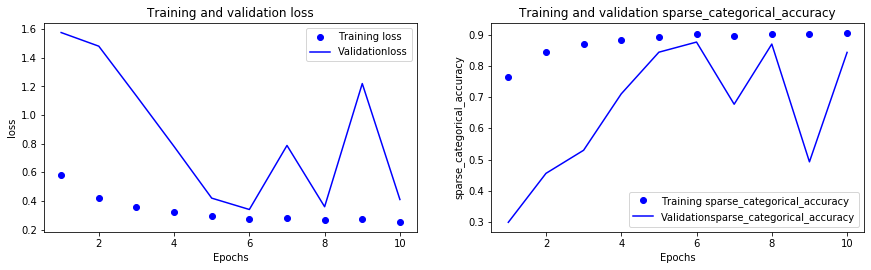

In [0]:
plot_history(history_base_line.history)

In [0]:
val_image_gen   = make_gen4unet(df_val,batch_size=1,seed=12)

img_val,mask_val = next(val_image_gen)

Found 578 validated image filenames.
Found 578 validated image filenames.


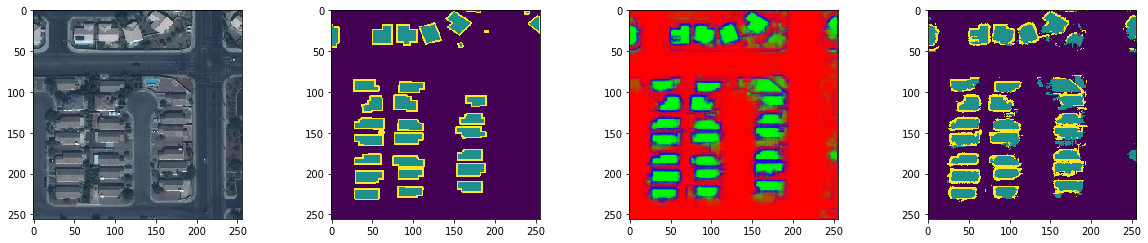

In [0]:
_ = validate_image(img_val,mask_val,model_base_line)

## Baseline Model Analysis

<font size = '+1'>Here you can analyse model's tensors and see what is happing in the learning process.<br>
Cells below basically reproduce tensorboard tensor histogram visualization. Additionally histograms below are stored in the notebook. </font>

In [0]:
def get_event_file(log_dir):
  event_files = glob.glob(os.path.join(log_dir,'train','*v2'))
  return event_files[0] 

def get_events_of_tensor(event_file,tensor_name):

  events = []
  for e in tf.compat.v1.train.summary_iterator(event_file):
    events.append(e)
    
  events_of_tensor = []
  
  for e in events:
    if len(e.summary.value)>0:      
      if re.compile('.*{}$'.format(tensor_name)).match(e.summary.value[0].tag):                   
        events_of_tensor.append(e)

  print('Found {} events of tensor {}'.format(len(events_of_tensor),tensor_name))

  return events_of_tensor

def get_coef_histogram(events_of_tensor):

  coef_hist = []

  for e in events_of_tensor:

    bucket_limit = np.array(e.summary.value[0].histo.bucket_limit)
    bucket = np.array(e.summary.value[0].histo.bucket)
    
    bucket_limit[-1] = bucket_limit[-2] + bucket_limit[-2] - bucket_limit[-3]
    
    bucket_limit,bucket = smooth_hist(bucket_limit,bucket)

    bucket_limit = np.insert(bucket_limit,0,bucket_limit[0] - bucket_limit[1]+bucket_limit[0])
    bucket = np.insert(bucket,0,0)
    
    coef_hist.append(np.stack([bucket_limit,bucket],axis=1))

  return np.stack(coef_hist)

def smooth_hist(bins,bins_val):

  bins = np.array(bins)
  bins_val = np.array(bins_val)

  min_bin = bins.min()
  max_bin = bins.max()

  new_bins = np.linspace(min_bin,max_bin,30)

  new_bins_val = []
  for i in range(len(new_bins)-1):
    
    new_bin_value = np.sum(bins_val[np.logical_and(new_bins[i]<bins,bins<=new_bins[i+1])])
    new_bins_val.append(new_bin_value)

  new_bins = new_bins[1:]
  

  return new_bins,np.array(new_bins_val)

def draw_coef_hist(coef_hist,ax):

  epochs = len(coef_hist)

  zs = np.array(range(epochs))
  
  for i in zs:

    verts = coef_hist[i]

    poly = PolyCollection([verts], facecolors=(1.0,0.3,0), edgecolors = (0,0,0))

    #harcoded alpha increment
    poly.set_alpha(0.8-i*0.05)
    ax.add_collection3d(poly, zs=[zs[i]], zdir='y')  


  x_min = coef_hist[:,:,0].min()
  x_max = coef_hist[:,:,0].max()

  z_max = coef_hist[:,:,1].max()

  ax.set_xlabel('X')
  ax.set_xlim3d(x_min, x_max)
  ax.set_ylabel('EPOCH NUM')
  ax.set_ylim3d(0, epochs)
  ax.set_zlabel('Z')
  ax.set_zlim3d(0, z_max)
  
  return

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`
Found 10 events of tensor conv2d_9/bias_0
Found 10 events of tensor conv2d_10/bias_0
Found 10 events of tensor conv2d_9/kernel_0
Found 10 events of tensor conv2d_10/kernel_0


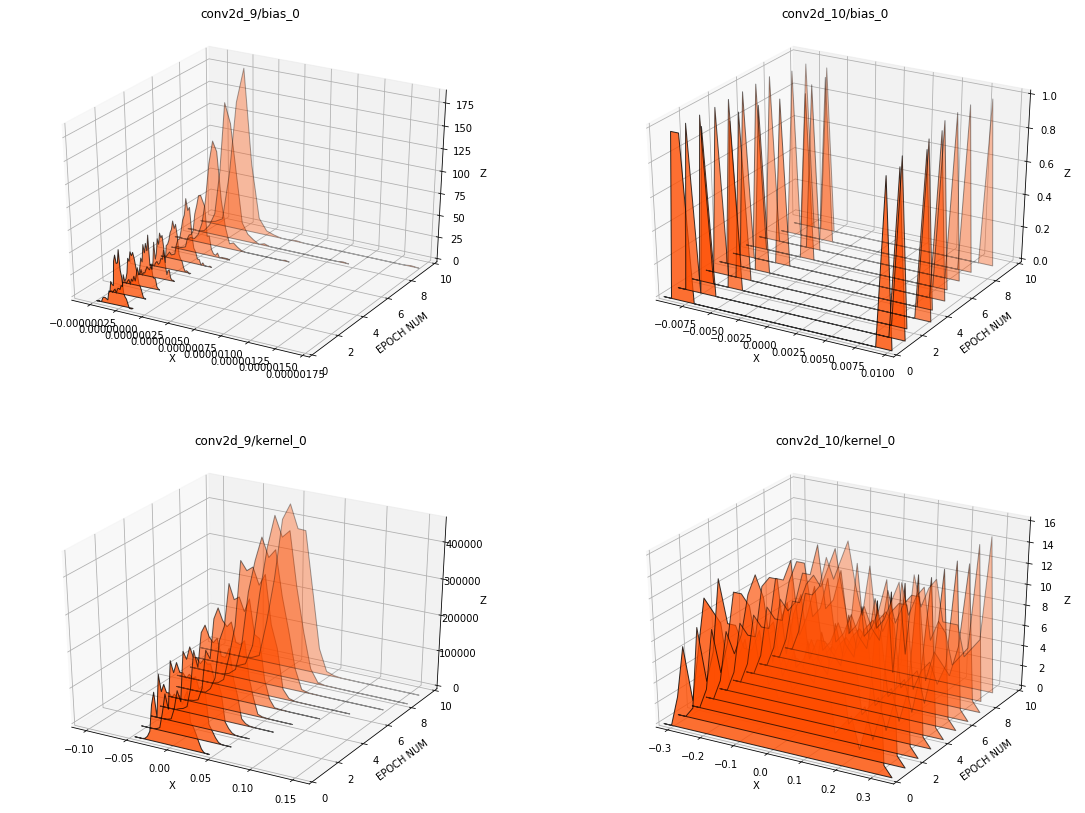

In [0]:
log_dir = 'log_dir/base_line/0'
event_file = get_event_file(log_dir)

fig = plt.figure(figsize=1.5*np.array([2*6.4, 2*4.8]))

tensor_name = 'conv2d_9/bias_0'
events_of_tensor = get_events_of_tensor(event_file,tensor_name)
coef_hist = get_coef_histogram(events_of_tensor)

ax1 = fig.add_subplot(2, 2, 1, projection='3d')
draw_coef_hist(coef_hist,ax1)
ax1.title.set_text(tensor_name)


tensor_name = 'conv2d_10/bias_0'
events_of_tensor = get_events_of_tensor(event_file,tensor_name)
coef_hist = get_coef_histogram(events_of_tensor)

ax2 = fig.add_subplot(2, 2, 2, projection='3d')
draw_coef_hist(coef_hist,ax2)
ax2.title.set_text(tensor_name)



tensor_name = 'conv2d_9/kernel_0'
events_of_tensor = get_events_of_tensor(event_file,tensor_name)
coef_hist = get_coef_histogram(events_of_tensor)

ax1 = fig.add_subplot(2, 2, 3, projection='3d')
draw_coef_hist(coef_hist,ax1)
ax1.title.set_text(tensor_name)



tensor_name = 'conv2d_10/kernel_0'
events_of_tensor = get_events_of_tensor(event_file,tensor_name)
coef_hist = get_coef_histogram(events_of_tensor)

ax2 = fig.add_subplot(2, 2, 4, projection='3d')
draw_coef_hist(coef_hist,ax2)
ax2.title.set_text(tensor_name)

plt.show()

# Improoved Unet

## Improoved Unet Training

In [0]:
model_improoved = unetModel(final_reduce=True, final_reduce_n_channel=30)

model_improoved.compile(optimizer='adam',metrics = ['sparse_categorical_accuracy'],loss= 'sparse_categorical_crossentropy')

In [0]:
%%time
logdir = 'log_dir/improoved/0'

os.makedirs(logdir,exist_ok=True)


callbacks = [keras.callbacks.TensorBoard(log_dir=logdir,
                                        histogram_freq=1,
                                        update_freq = 'epoch',                                     
                                        write_graph=True
                                        )]
                                        

history_model_improoved = model_improoved.fit_generator(train_gen, 
                              steps_per_epoch=25, 
                              epochs=10,
                              verbose=1, 
                              validation_data=val_gen,
                              validation_steps=19,
                              callbacks=callbacks)

Epoch 1/10
25/25 [==============================] - 16s 655ms/step - loss: 0.6749 - sparse_categorical_accuracy: 0.7804 - val_loss: 11.7993 - val_sparse_categorical_accuracy: 0.1736
Epoch 2/10
25/25 [==============================] - 15s 584ms/step - loss: 0.4321 - sparse_categorical_accuracy: 0.8407 - val_loss: 4.1147 - val_sparse_categorical_accuracy: 0.2069
Epoch 3/10
25/25 [==============================] - 15s 586ms/step - loss: 0.3794 - sparse_categorical_accuracy: 0.8608 - val_loss: 1.2927 - val_sparse_categorical_accuracy: 0.5434
Epoch 4/10
25/25 [==============================] - 14s 572ms/step - loss: 0.3485 - sparse_categorical_accuracy: 0.8740 - val_loss: 0.9346 - val_sparse_categorical_accuracy: 0.6420
Epoch 5/10
25/25 [==============================] - 15s 582ms/step - loss: 0.3148 - sparse_categorical_accuracy: 0.8841 - val_loss: 0.4725 - val_sparse_categorical_accuracy: 0.8240
Epoch 6/10
25/25 [==============================] - 14s 577ms/step - loss: 0.3059 - sparse_cat

## Improoved Unet Validation

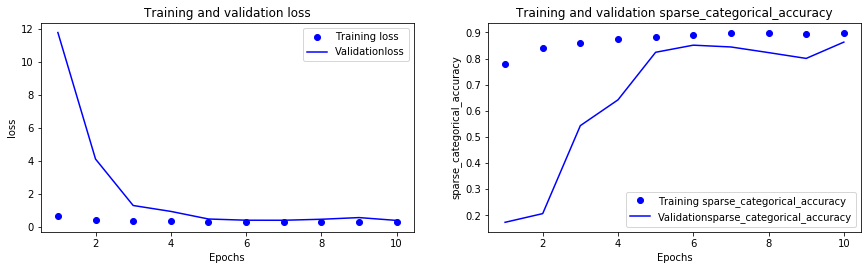

In [0]:
plot_history(history_model_improoved.history)

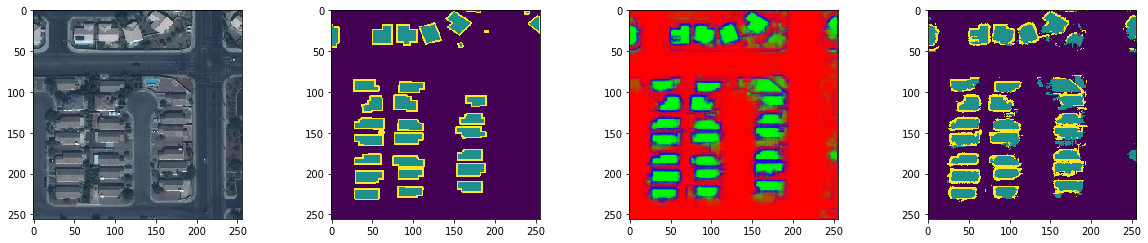

In [0]:
_ = validate_image(img_val,mask_val,model_base_line)

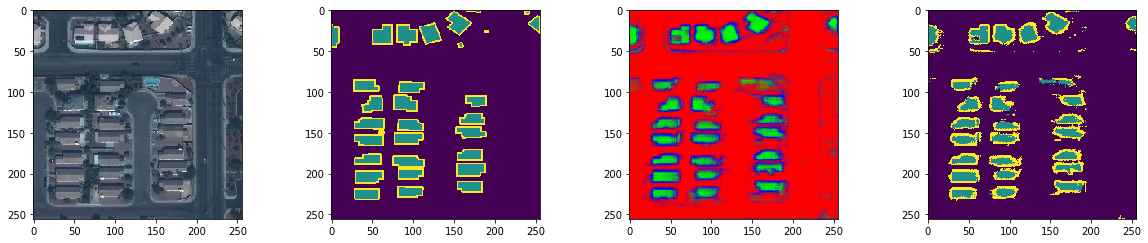

In [0]:
_ = validate_image(img_val,mask_val,model_improoved)

## Improoved Unet Analysis

Found 10 events of tensor conv2d_20/bias_0
Found 10 events of tensor conv2d_21/bias_0
Found 10 events of tensor conv2d_20/kernel_0
Found 10 events of tensor conv2d_21/kernel_0


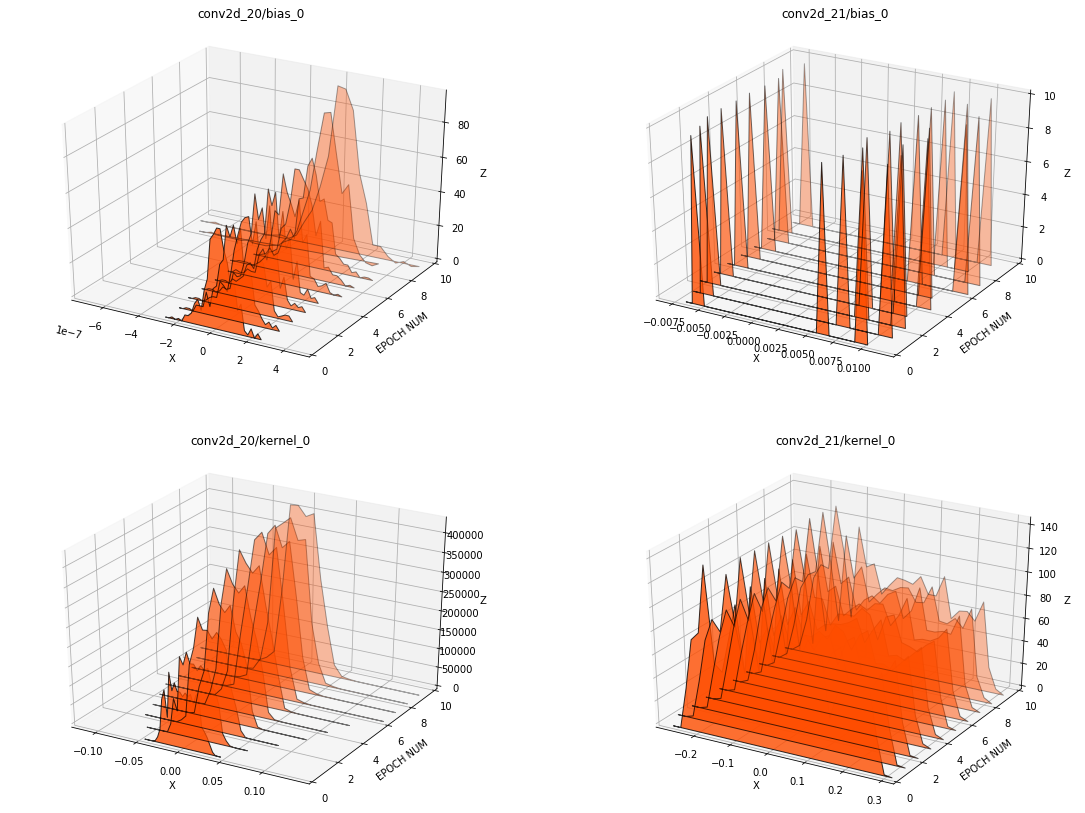

In [0]:
log_dir = 'log_dir/improoved/0'
event_file = get_event_file(log_dir)

fig = plt.figure(figsize=1.5*np.array([2*6.4, 2*4.8]))

tensor_name = 'conv2d_20/bias_0'
events_of_tensor = get_events_of_tensor(event_file,tensor_name)
coef_hist = get_coef_histogram(events_of_tensor)

ax1 = fig.add_subplot(2, 2, 1, projection='3d')
draw_coef_hist(coef_hist,ax1)
ax1.title.set_text(tensor_name)


tensor_name = 'conv2d_21/bias_0'
events_of_tensor = get_events_of_tensor(event_file,tensor_name)
coef_hist = get_coef_histogram(events_of_tensor)

ax2 = fig.add_subplot(2, 2, 2, projection='3d')
draw_coef_hist(coef_hist,ax2)
ax2.title.set_text(tensor_name)



tensor_name = 'conv2d_20/kernel_0'
events_of_tensor = get_events_of_tensor(event_file,tensor_name)
coef_hist = get_coef_histogram(events_of_tensor)

ax1 = fig.add_subplot(2, 2, 3, projection='3d')
draw_coef_hist(coef_hist,ax1)
ax1.title.set_text(tensor_name)



tensor_name = 'conv2d_21/kernel_0'
events_of_tensor = get_events_of_tensor(event_file,tensor_name)
coef_hist = get_coef_histogram(events_of_tensor)

ax2 = fig.add_subplot(2, 2, 4, projection='3d')
draw_coef_hist(coef_hist,ax2)
ax2.title.set_text(tensor_name)

plt.show()

<font size='+1'>It looks like models with higher number of filters per class in the final layer are less prone to overfit and perform better.<br>
Let's now explore how model's perfomance depends on the number of filters per class.</font>

## Exploration of filter number with Hyperopt

In [0]:
def objective(epochs=10,best_loss=10):

  best_loss = [best_loss]
  
  def _objective(final_reduce_n_channel):

    if not final_reduce_n_channel:
      model = unetModel(final_reduce=False)
    else:
      #round to the closes lower integer devisible by 3, 3 is the number of classes
      final_reduce_n_channel = int((final_reduce_n_channel // 3) * 3)
      model = unetModel(final_reduce=True,final_reduce_n_channel=final_reduce_n_channel)

    model.compile(optimizer='adam',metrics = ['sparse_categorical_accuracy'],loss= 'sparse_categorical_crossentropy')

    history = model.fit_generator(train_gen, 
                                  steps_per_epoch=25, 
                                  epochs=epochs,
                                  verbose=0, 
                                  validation_data=val_gen,
                                  validation_steps=19)
    
    

    loss = history.history['val_loss'][-1]
    hst_dmp = pickle.dumps(history.history)

    if loss < best_loss[0]:
      best_loss[0] = loss
      model_weights_dmp = pickle.dumps(model.get_weights())
      model_json_dmp = pickle.dumps(model.to_json())
    else:
      model_weights_dmp = None
      model_json_dmp = None

    #There is a chance that if model pointer persists, then memory leakage occur 
    del model
    del history

      
    return {
          'loss': loss,
          'status': STATUS_OK,
          'attachments':
              {'history' : hst_dmp,
               'model_weights' : model_weights_dmp,
               'model_json' : model_json_dmp}
          }
  
  return _objective

In [0]:
space = hp.quniform('quniform', 3, 120,0.8)

trials = Trials()

best = fmin(objective(epochs=10),
    space=space,
    algo=tpe.suggest,
    max_evals=80,
    trials=trials)

print(best)

100%|██████████| 80/80 [3:08:29<00:00, 140.97s/it, best loss: 0.2411159363232161]
{'quniform': 59.2}


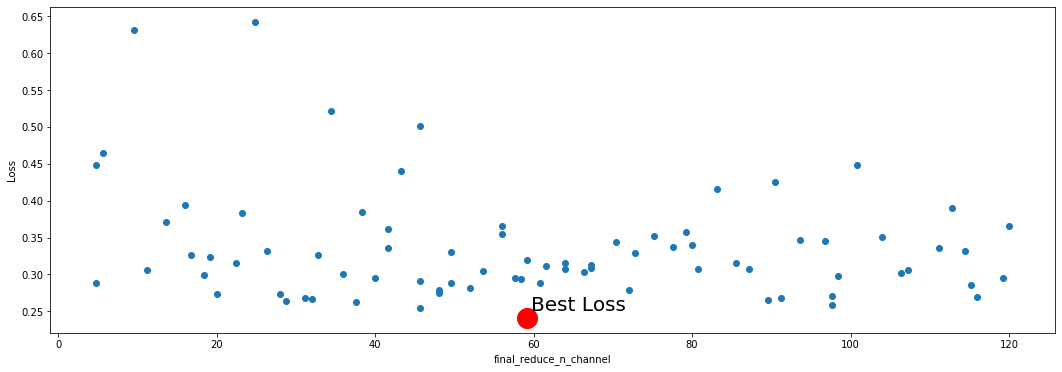

In [0]:
n_chns = []
losses = []
for i in range(len(trials.trials)):
  n_chn = trials.trials[i]['misc']['vals']['quniform']
  if not n_chn:
    n_chn = [-1]

  n_chns.append(n_chn[0])
  losses.append(trials.trials[i]['result']['loss'])


plt.figure(figsize=(18,6))

best_loss_index = np.argmin(losses)
best_loss = losses[best_loss_index]
best_loss_nch = n_chns[best_loss_index]

plt.plot(best_loss_nch,best_loss,color='r', marker='o', markersize=20)
plt.text(best_loss_nch + 0.5, best_loss + .01, 'Best Loss', fontsize=20,color='k')

plt.scatter(n_chns, losses)
plt.xlabel('final_reduce_n_channel')
plt.ylabel('Loss')

plt.show()

In [0]:
best_model_weights_dmp = trials.trial_attachments(trials.trials[best_loss_index])['model_weights']
best_model_weights = pickle.loads(best_model_weights_dmp)

best_model_json_dmp = trials.trial_attachments(trials.trials[best_loss_index])['model_json']
best_model_json = pickle.loads(best_model_json_dmp)

best_model = keras.models.model_from_json(best_model_json)
best_model.set_weights(best_model_weights)


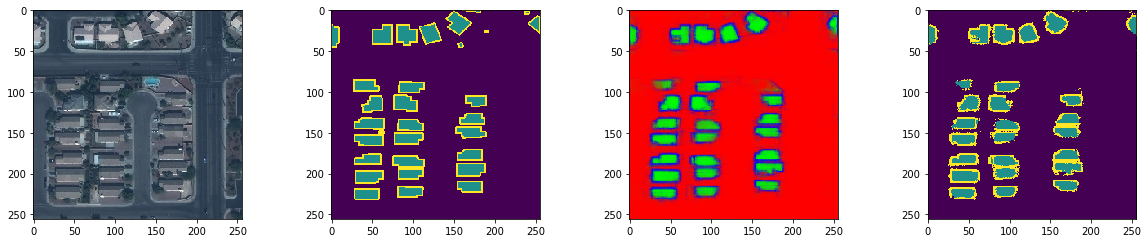

In [0]:
_ = validate_image(img_val,mask_val,best_model)

Base line output for comparison

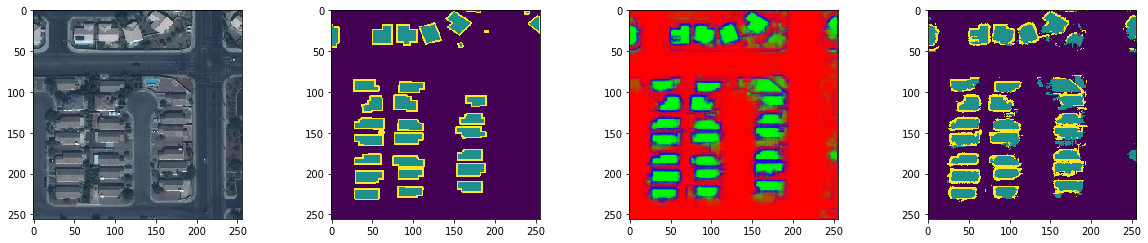

In [0]:
_ = validate_image(img_val,mask_val,model_base_line)

# Test F1 all classes

In [0]:
test_img,test_mask = next(test_gen)
test_mask = np.squeeze(test_mask)

test_mask_pred = best_model.predict(test_img)
test_mask_pred_rend = np.argmax(test_mask_pred,axis=-1)

cfm = multilabel_confusion_matrix(test_mask.flatten(),test_mask_pred_rend.flatten())

In [0]:
for i in range(3):
  prec = cfm[i,1,1]/(cfm[i,1,1]+cfm[i,0,1])
  recall= cfm[i,1,1]/(cfm[i,1,1]+cfm[i,1,0])
  f1  = 2*prec*recall/(prec+recall)
  print('F1 score for class {} :'.format(i),f1)

F1 score for class 0 : 0.9557618425516154
F1 score for class 1 : 0.8207834377347321
F1 score for class 2 : 0.4910952191472297


# TensorBoard

In [0]:
#If you are running notebook in Google colab, Sometimes it is necessaty to run this cell twice to start tensorboard extension

%tensorboard --logdir log_dir/base_line/0

In [0]:
#####stop tensorboard

!kill `ps aux|egrep tensorboard|grep -v grep|awk '{print $2}'`; echo "Stopping tensorboard res $?"